In [78]:
import warnings
import os
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


from torchinfo import summary

# 데이터 경로 설정

In [79]:
data_dir = '/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data'

print(os.getcwd())

/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog


# 초기 이미지 개수 확인

In [80]:
subfolders = ['test_set', 'training_set']

total_file_counter = 0

for subfolder in subfolders:
    folder_path = os.path.join(data_dir, subfolder)
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += sum(1 for file in files if file.lower().endswith('.jpg'))
    print(f"{subfolder} 폴더 내 JPG 파일 수: {count}개")
    total_file_counter += count

print(f'총 파일 개수: {total_file_counter}개')

test_set 폴더 내 JPG 파일 수: 2023개
training_set 폴더 내 JPG 파일 수: 8005개
총 파일 개수: 10028개


# 이미지 파일 추출

In [81]:
from os.path import dirname
paths = []
data_sets = []
labels = []

def load_images(base_dir):
    images = []
    for root, _, files in os.walk(base_dir):
        for file_name in files:
            if file_name.lower().endswith('.jpg'):
                file_path = os.path.join(root, file_name)
                paths.append(file_path)

                # 이미지 로딩 및 색상 변환
                img = cv2.imread(file_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)

                # 상대 경로 파싱 (ex: training_set/cats/...)
                rel_path = os.path.relpath(file_path, base_dir)
                path_parts = rel_path.split(os.path.sep)

                if len(path_parts) >= 3:
                    # 1. "training_set" → "training", "test_set" → "test"
                    dataset_type = path_parts[0].replace('_set', '')   # 정확히 '_set'만 제거

                    # 2. "cats" → "cat", "dogs" → "dog"
                    label_type = path_parts[1][:-1]  # 's'만 제거 (cat/dog)

                    data_set_label = f"{dataset_type}_{label_type}"
                    data_sets.append(data_set_label)

                    # label도 동일하게 구성
                    labels.append(data_set_label)
                else:
                    data_sets.append('N/A')
                    labels.append('N/A')

    return images

In [82]:
images = load_images(data_dir)

In [83]:
print(set(data_sets))
# → {'training_cat', 'training_dog', 'test_cat', 'test_dog'}

print(set(labels))
# → {'training_cat', 'training_dog', 'test_cat', 'test_dog'}


{'training_dog', 'training_cat', 'test_dog', 'test_cat'}
{'training_dog', 'training_cat', 'test_dog', 'test_cat'}


In [84]:
print(len(paths))
print(len(data_sets))
print(len(labels))

10028
10028
10028


In [85]:
pd.set_option('display.max_colwidth', 400)

df = pd.DataFrame({
    'path': paths,
    'dataset': data_sets,
    'label': labels
})

print('data_df shape:', df.shape)

df

data_df shape: (10028, 3)


,path,dataset,label
0,/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data/training_set/dogs/dog.1753.jpg,training_dog,training_dog
1,/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data/training_set/dogs/dog.3144.jpg,training_dog,training_dog
2,/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data/training_set/dogs/dog.775.jpg,training_dog,training_dog
3,/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data/training_set/dogs/dog.3622.jpg,training_dog,training_dog
4,/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data/training_set/dogs/dog.1035.jpg,training_dog,training_dog
...,...,...,...
10023,/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data/test_set/cats/cat.4358.jpg,test_cat,test_cat
10024,/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data/test_set/cats/cat.4364.jpg,test_cat,test_cat
10025,/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data/test_set/cats/cat.4402.jpg,test_cat,test_cat
10026,/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data/test_set/cats/cat.4416.jpg,test_cat,test_cat


In [86]:
df['dataset'].value_counts()

dataset
training_dog    4005
training_cat    4000
test_dog        1012
test_cat        1011
Name: count, dtype: int64

# 데이터 셋

In [ ]:
# ✅ 패딩 후 Resize
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = max(w, h)
        pad_left = (max_wh - w) // 2
        pad_top = (max_wh - h) // 2
        pad_right = max_wh - w - pad_left
        pad_bottom = max_wh - h - pad_top
        return transforms.functional.pad(image, (pad_left, pad_top, pad_right, pad_bottom), fill=0)

# ✅ 전처리 정의
IMG_MEANS = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

preprocess = transforms.Compose([
    SquarePad(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMG_MEANS, std=IMG_STD)
])


class CatDogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []
        for label, cls in enumerate(['cats', 'dogs']):
            cls_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_dir):
                if not fname.lower().endswith('.jpg'):
                    continue  # ⛔️ .DS_Store 등 무시
                path = os.path.join(cls_dir, fname)
                self.samples.append((path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label, path

In [ ]:
BATCH_SIZE = 32

train_dataset = CatDogDataset("data/training_set", transform=preprocess)
test_dataset = CatDogDataset("data/test_set", transform=preprocess)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [159]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
model.classifier[6] = nn.Linear(4096, 2)  # 2-class: cat/dog
model = model.to(device)


In [160]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

def train(model, loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for imgs, labels, _ in tqdm(loader, desc=f"Epoch {epoch+1}"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} Loss: {total_loss / len(loader):.4f}")


In [161]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels, _ in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    print(classification_report(all_labels, all_preds, target_names=["Cat", "Dog"]))
    print(confusion_matrix(all_labels, all_preds))


In [170]:
def denormalize_for_display(tensor):
    img = tensor.cpu().permute(1, 2, 0).numpy()
    img = img * np.array(IMG_STD) + np.array(IMG_MEANS)
    return np.clip(img, 0, 1)

def show_batch(dataloader, model=None, num_images=30, class_names={0: "Cat", 1: "Dog"}):
    if model:
        model.eval()
    shown = 0

    with torch.no_grad():
        for images, labels, paths in dataloader:
            batch_size = images.size(0)
            preds = []

            if model is not None:
                outputs = model(images.to(next(model.parameters()).device))
                preds = torch.argmax(outputs, dim=1).cpu()

            fig, axes = plt.subplots(nrows=int(np.ceil(num_images / 6)), ncols=6, figsize=(15, num_images // 2))
            axes = axes.flatten()

            for i in range(min(num_images, batch_size)):
                img = denormalize_for_display(images[i])
                label = class_names[labels[i].item()]
                pred_label = class_names[preds[i].item()] if len(preds) > 0 else "?"

                axes[i].imshow(img)
                axes[i].set_title(f"GT: {label}\nPred: {pred_label}")
                axes[i].axis('off')

                shown += 1
                if shown >= num_images:
                    break

            plt.tight_layout()
            plt.show()
            break



# 모델 학습

Epoch 1: 100%|██████████| 251/251 [03:09<00:00,  1.33it/s]


Epoch 1 Loss: 0.1631


Epoch 2: 100%|██████████| 251/251 [02:43<00:00,  1.54it/s]


Epoch 2 Loss: 0.0697


Epoch 3: 100%|██████████| 251/251 [02:44<00:00,  1.53it/s]


Epoch 3 Loss: 0.0476


Epoch 4: 100%|██████████| 251/251 [02:50<00:00,  1.47it/s]


Epoch 4 Loss: 0.0335


Epoch 5: 100%|██████████| 251/251 [02:50<00:00,  1.48it/s]


Epoch 5 Loss: 0.0224
              precision    recall  f1-score   support

         Cat       0.94      0.97      0.96      1011
         Dog       0.97      0.94      0.96      1012

    accuracy                           0.96      2023
   macro avg       0.96      0.96      0.96      2023
weighted avg       0.96      0.96      0.96      2023

[[985  26]
 [ 63 949]]


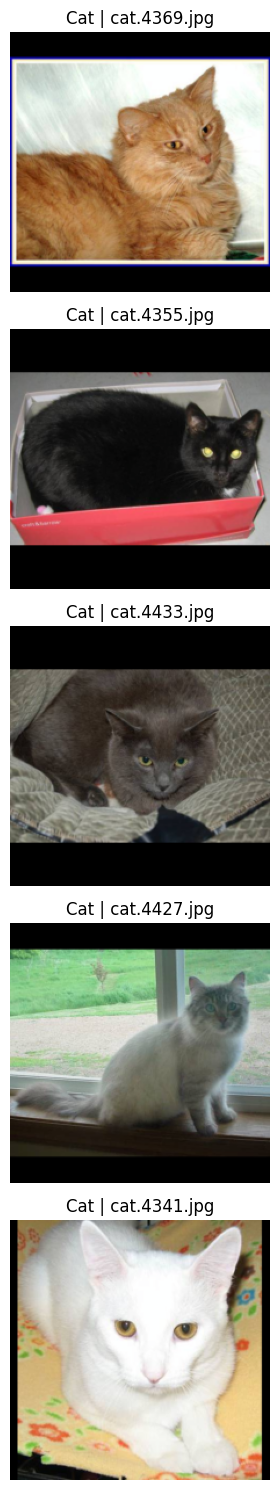

In [ ]:
train(model, train_loader, epochs=5)


# 평가

              precision    recall  f1-score   support

         Cat       0.94      0.97      0.96      1011
         Dog       0.97      0.94      0.96      1012

    accuracy                           0.96      2023
   macro avg       0.96      0.96      0.96      2023
weighted avg       0.96      0.96      0.96      2023

[[985  26]
 [ 63 949]]


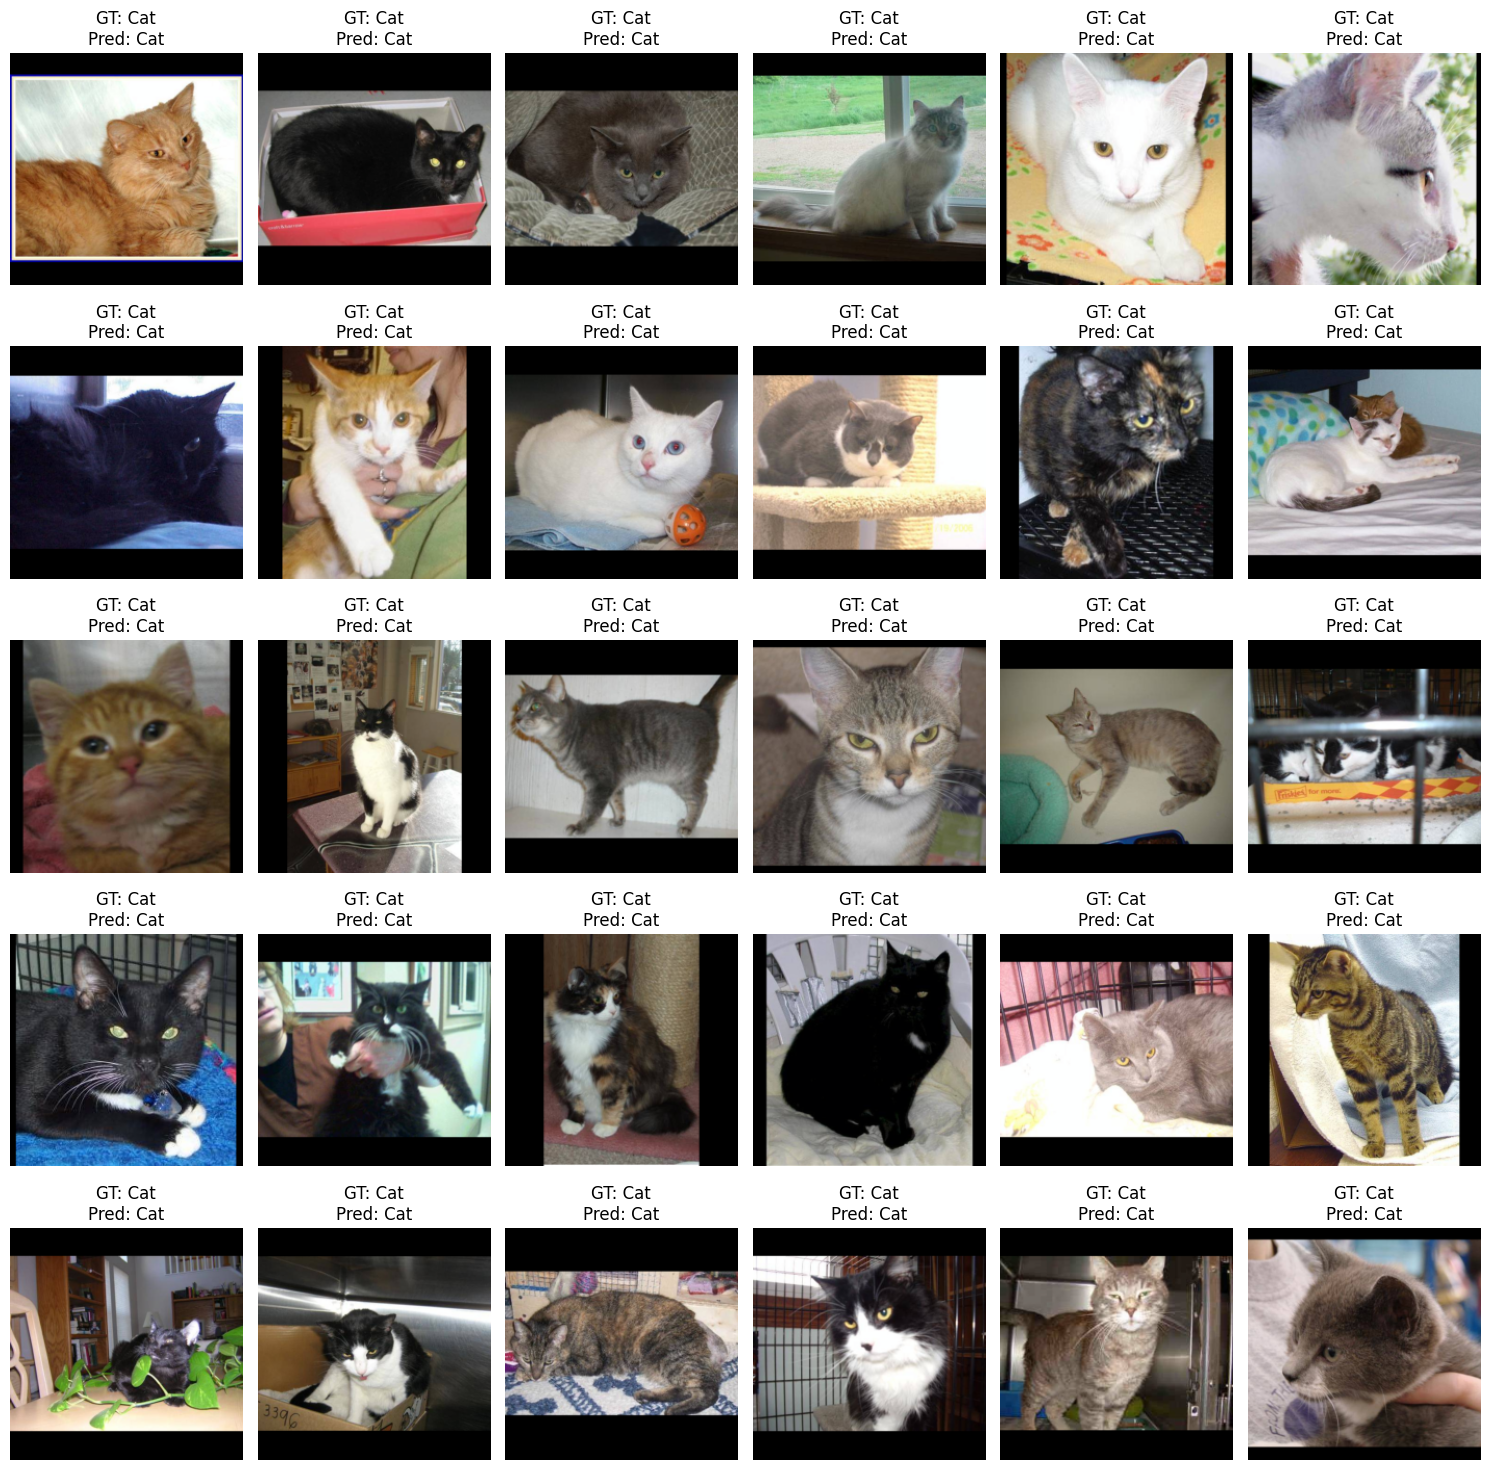

In [171]:

evaluate(model, test_loader)
show_batch(test_loader, model=model, num_images=30)

In [179]:
def predict_single_image(image_path, model, class_names={0: "Cat", 1: "Dog"}):
    model.eval()
    device = next(model.parameters()).device

    # 🔹 이미지 로드 및 전처리
    img = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    # 🔹 예측
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred].item()

    # 🔹 시각화
    plt.imshow(img)
    plt.title(f"Prediction: {class_names[pred]} ({confidence:.2%})\n{os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()

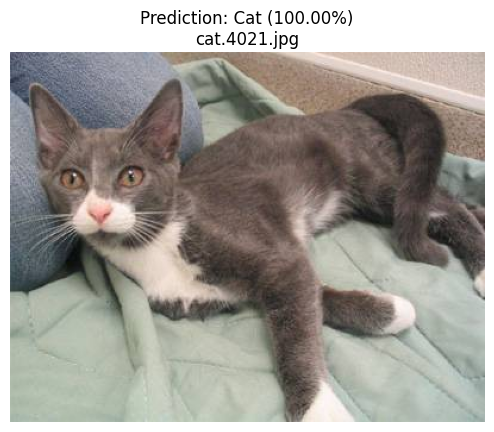

In [ ]:
image_path = "data/test_set/cats/cat.4021.jpg"
predict_single_image(image_path, model)
